In [29]:
import math
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from IPython.display import display, Markdown
from glob2 import glob
from cv2 import dnn

PATH = 'C:/Users/DINH QUOC BAO/Documents/PySimpleGUI-Photo-Colorizer-master/image'
# PATH = 'picture'

In [30]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5*np.square((x-mean)/std))

# Membership Functions:
def ExtremelyDark(x, M):
    return G(x, -50, M/6)

def VeryDark(x, M):
    return G(x, 0, M/6)

def Dark(x, M):
    return G(x, M/2, M/6)

def SlightlyDark(x, M):
    return G(x, 5*M/6, M/6)

def SlightlyBright(x, M):
    return G(x, M+(255-M)/6, (255-M)/6)

def Bright(x, M):
    return G(x, M+(255-M)/2, (255-M)/6)

def VeryBright(x, M):
    return G(x, 255, (255-M)/6)

def ExtremelyBright(x, M):
    return G(x, 305, (255-M)/6)

In [31]:
def OutputFuzzySet(x, f, M, thres):
    x = np.array(x)
    result = f(x, M)
    result[result > thres] = thres
    return result

def AggregateFuzzySets(fuzzy_sets):
    return np.max(np.stack(fuzzy_sets), axis=0)

def Infer(i, M, get_fuzzy_set=False):
    # Calculate degree of membership for each class
    VD = VeryDark(i, M)
    Da = Dark(i, M)
    SD = SlightlyDark(i, M)
    SB = SlightlyBright(i, M)
    Br = Bright(i, M)
    VB = VeryBright(i, M)
    
    # Fuzzy Inference:
    x = np.arange(-50, 306)
    Inferences = (
        OutputFuzzySet(x, ExtremelyDark, M, VD),
        OutputFuzzySet(x, VeryDark, M, Da),
        OutputFuzzySet(x, Dark, M, SD),
        OutputFuzzySet(x, Bright, M, SB),
        OutputFuzzySet(x, VeryBright, M, Br),
        OutputFuzzySet(x, ExtremelyBright, M, VB)
    )
    
    # Calculate AggregatedFuzzySet:
    fuzzy_output = AggregateFuzzySets(Inferences)
    
    # Calculate crisp value of centroid
    if get_fuzzy_set:
        return np.average(x, weights=fuzzy_output), fuzzy_output
    return np.average(x, weights=fuzzy_output)

In [32]:
# Proposed fuzzy method
def FuzzyContrastEnhance(rgb):
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    
    # Get L channel
    l = lab[:, :, 0]
    
    # Calculate M value
    M = np.mean(l)
    if M < 128:
        M = 127 - (127 - M)/2
    else:
        M = 128 + M/2
        
    # Precompute the fuzzy transform
    x = list(range(-50,306))
    FuzzyTransform = dict(zip(x,[Infer(np.array([i]), M) for i in x]))
    
    # Apply the transform to l channel
    u, inv = np.unique(l, return_inverse = True)
    l = np.array([FuzzyTransform[i] for i in u])[inv].reshape(l.shape)
    
    # Min-max scale the output L channel to fit (0, 255):
    Min = np.min(l)
    Max = np.max(l)
    lab[:, :, 0] = (l - Min)/(Max - Min) * 255
    
    # Convert LAB to RGB
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [33]:
iname = 'C:/Users/DINH QUOC BAO/Documents/PySimpleGUI-Photo-Colorizer-master/image/Broadway_tower_grayscale.jpg'
# iname = 'abc.png'
#read image
img = np.array(cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB))
imgori=np.array(cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB))
img = FuzzyContrastEnhance(img)
img=img

In [34]:
# #--------Model file paths--------#
# proto_file = 'Model\colorization_deploy_v2.prototxt'
# model_file = 'Model\colorization_release_v2.caffemodel'
# hull_pts = 'Model\pts_in_hull.npy'
# img_path = 'Broadway_tower_grayscale.jpg'
# # img_path = 'einstein-portrait-oxford_1.jpg'
# #--------------#--------------#

# #--------Reading the model params--------#
# net = dnn.readNetFromCaffe(proto_file,model_file)
# kernel = np.load(hull_pts)
# #-----------------------------------#---------------------#

# #-----Reading and preprocessing image--------#
# # img = cv2.imread(img_path)
# scaled = img.astype("float32") / 255.0
# lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
# #-----------------------------------#---------------------#

# # add the cluster centers as 1x1 convolutions to the model
# class8 = net.getLayerId("class8_ab")
# conv8 = net.getLayerId("conv8_313_rh")
# pts = kernel.transpose().reshape(2, 313, 1, 1)
# net.getLayer(class8).blobs = [pts.astype("float32")]
# net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
# #-----------------------------------#---------------------#

# # we'll resize the image for the network
# resized = cv2.resize(lab_img, (224, 224))
# # split the L channel
# L = cv2.split(resized)[0]
# # mean subtraction
# L -= 50
# #-----------------------------------#---------------------#

# # predicting the ab channels from the input L channel

# net.setInput(cv2.dnn.blobFromImage(L))
# ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
# # resize the predicted 'ab' volume to the same dimensions as our
# # input image
# ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))


# # Take the L channel from the image
# L = cv2.split(lab_img)[0]
# # Join the L channel with predicted ab channel
# colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

# # Then convert the image from Lab to BGR
# colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
# colorized = np.clip(colorized, 0, 1)

# # change the image to 0-255 range and convert it from float32 to int
# colorized = (255 * colorized).astype("uint8")

# # Let's resize the images and show them together
# img = cv2.resize(img,(640,640))
# colorized = cv2.resize(colorized,(640,640))

# result = cv2.hconcat([img,colorized])

# cv2.imshow("Grayscale -> Colour", result)

# cv2.waitKey(0)


In [35]:
#--------Model file paths--------#
proto_file = 'Model\colorization_deploy_v2.prototxt'
model_file = 'Model\colorization_release_v2.caffemodel'
hull_pts = 'Model\pts_in_hull.npy'
# img_path = 'Broadway_tower_grayscale.jpg'
#--------------#--------------#

#--------Reading the model params--------#
net = dnn.readNetFromCaffe(proto_file,model_file)
kernel = np.load(hull_pts)
#-----------------------------------#---------------------#

#-----Reading and preprocessing image--------#
# img = cv2.imread(img_path)
scaled = img.astype("float32") / 255.0
lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
#-----------------------------------#---------------------#

# add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = kernel.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
#-----------------------------------#---------------------#

# we'll resize the image for the network
resized = cv2.resize(lab_img, (224, 224))
# split the L channel
L = cv2.split(resized)[0]
# mean subtraction
L -= 50
#-----------------------------------#---------------------#

# predicting the ab channels from the input L channel

net.setInput(cv2.dnn.blobFromImage(L))
ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
# resize the predicted 'ab' volume to the same dimensions as our
# input image
ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))


# Take the L channel from the image
L = cv2.split(lab_img)[0]
# Join the L channel with predicted ab channel
colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

# Then convert the image from Lab to BGR
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)

# change the image to 0-255 range and convert it from float32 to int
colorized = (255 * colorized).astype("uint8")

In [36]:
# #--------Model file paths--------#
# proto_file = 'Model\colorization_deploy_v2.prototxt'
# model_file = 'Model\colorization_release_v2.caffemodel'
# hull_pts = 'Model\pts_in_hull.npy'
# # img_path = 'Broadway_tower_grayscale.jpg'
# #--------------#--------------#

# #--------Reading the model params--------#
# net = dnn.readNetFromCaffe(proto_file,model_file)
# kernel = np.load(hull_pts)
# #-----------------------------------#---------------------#

# #-----Reading and preprocessing image--------#
# # img = cv2.imread(img_path)
# scaled = imgori.astype("float32") / 255.0
# lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
# #-----------------------------------#---------------------#

# # add the cluster centers as 1x1 convolutions to the model
# class8 = net.getLayerId("class8_ab")
# conv8 = net.getLayerId("conv8_313_rh")
# pts = kernel.transpose().reshape(2, 313, 1, 1)
# net.getLayer(class8).blobs = [pts.astype("float32")]
# net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]
# #-----------------------------------#---------------------#

# # we'll resize the image for the network
# resized = cv2.resize(lab_img, (224, 224))
# # split the L channel
# L = cv2.split(resized)[0]
# # mean subtraction
# L -= 50
# #-----------------------------------#---------------------#

# # predicting the ab channels from the input L channel

# net.setInput(cv2.dnn.blobFromImage(L))
# ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
# # resize the predicted 'ab' volume to the same dimensions as our
# # input image
# ab_channel = cv2.resize(ab_channel, (imgori.shape[1], imgori.shape[0]))


# # Take the L channel from the image
# L = cv2.split(lab_img)[0]
# # Join the L channel with predicted ab channel
# colorizedori = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

# # Then convert the image from Lab to BGR
# colorizedori = cv2.cvtColor(colorizedori , cv2.COLOR_LAB2BGR)
# colorizedori = np.clip(colorizedori, 0, 1)

# # change the image to 0-255 range and convert it from float32 to int
# colorizedori = (255 * colorizedori).astype("uint8")

-1

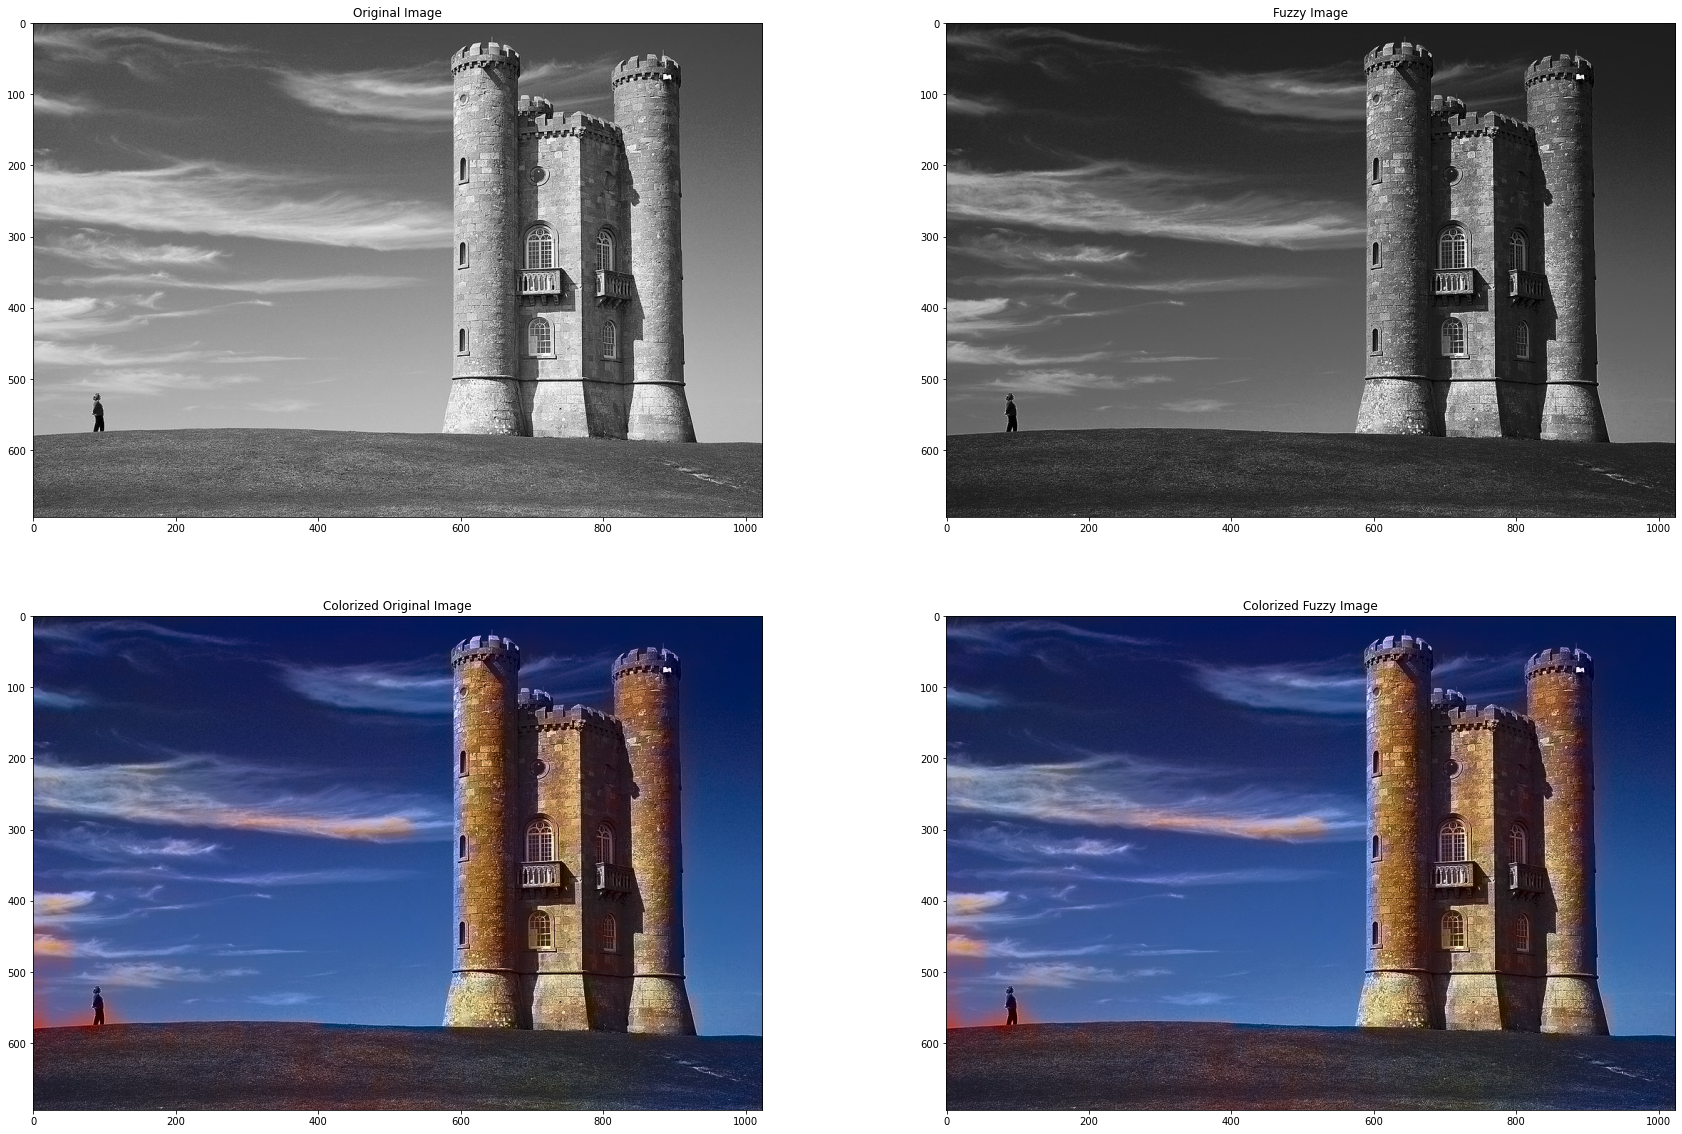

In [37]:
plt.figure(figsize=(30, 20))
plt.subplot(2, 2, 1)
plt.imshow(imgori)
plt.title('Original Image')
    
plt.subplot(2, 2, 2)
plt.imshow(img)
plt.title('Fuzzy Image')

plt.subplot(2, 2, 3)
plt.imshow(colorized[:,:,::-1])
plt.title('Colorized Original Image')

plt.subplot(2, 2, 4)
plt.imshow(colorized[:,:,::-1])
plt.title('Colorized Fuzzy Image')

cv2.waitKey(0)